In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import make_interp_spline

In [17]:
def workflow(df):

    # 使用 np.where() 根据 Profit 的正负值添加 result 列
    df['result'] = np.where(df['Profit'] > 0, 'won', 'lost')

    df  = df.copy(deep= True)
    rows = df[df[['CashedOut','Bonus', 'Profit']].isna().any(axis= 1)]
    df['Profit'].fillna(value = -1*df['Bet'],inplace  =True)
    df['CashedOut'].fillna(value = df['BustedAt'],inplace = True)
    df['Bonus'].fillna(value = 0.0,inplace = True)
    df['PlayDate'] = pd.to_datetime(df['PlayDate'])
    for col_type in ['Bet']:
        df['Next {}'.format(col_type)] = (df.sort_values(by=['PlayDate'], ascending=True)
                       .groupby('Username')[col_type].shift(-1))  
        
    df['Cumulative Profit'] = (df.sort_values(by=['PlayDate'], ascending=True)
                        .groupby('Username')['Profit'].agg(np.cumsum))
    # 假设 'Win' 是赢得的金额，'Bet' 是下注金额

    # 计算每个用户的期望 Profit
    expected_profit = df.groupby('Username')['Profit'].mean().reset_index()
    expected_profit.rename(columns={'Profit': 'Expected_Profit'}, inplace=True)
    # 将期望利润合并到原始数据
    df = df.merge(expected_profit, on='Username', how='left')


    df_sorted = df.sort_values(by =['Username','PlayDate'],ascending = [True,True])
    return df_sorted

def signal_analyze(df):
    df['Bet_Signal'] = df['Next Bet']-df['Bet']
    df['Bet_percent'] = (df['Next Bet']-df['Bet'])/df['Bet']
    df['encoded_Bet_Signal'] = '0'
    df.loc[df['Bet_Signal'] < 0 , 'encoded_Bet_Signal'] = '-'
    df.loc[df['Bet_Signal'] > 0 ,'encoded_Bet_Signal' ] = '+'

    df['encoded_Bet_percent'] = '0'
    df.loc[df['Bet_percent'] < 0 , 'encoded_Bet_percent'] = '-'
    df.loc[df['Bet_percent'] > 0 , 'encoded_Bet_percent'] = '+'
    return df


C:\Users\wang_\AppData\Local\Temp\ipykernel_21756\930691146.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Profit'].fillna(value = -1*df['Bet'],inplace  =True)
C:\Users\wang_\AppData\Local\Temp\ipykernel_21756\930691146.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

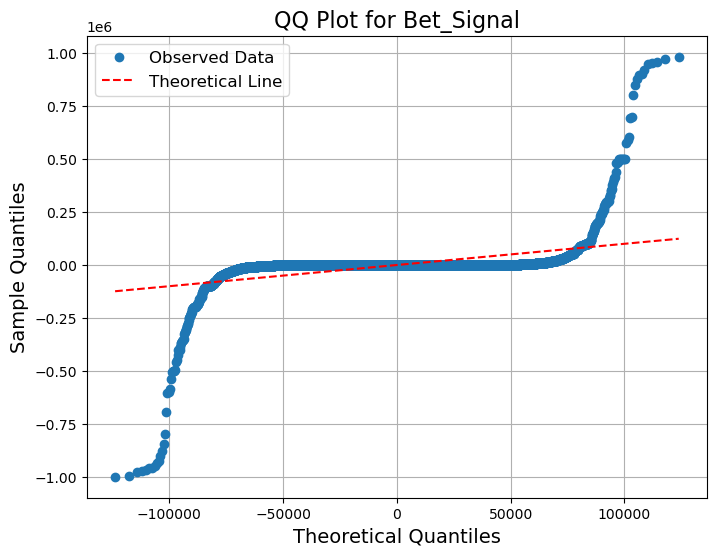

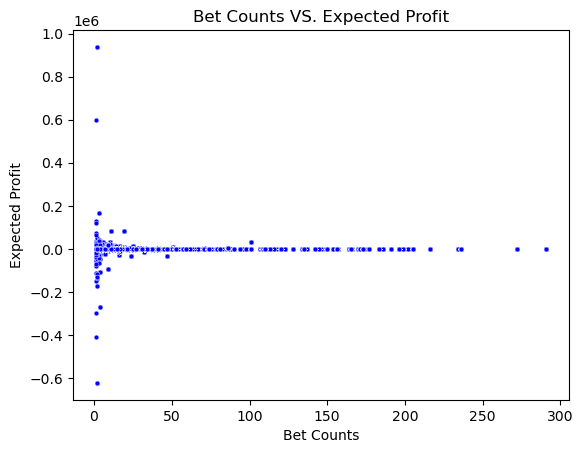

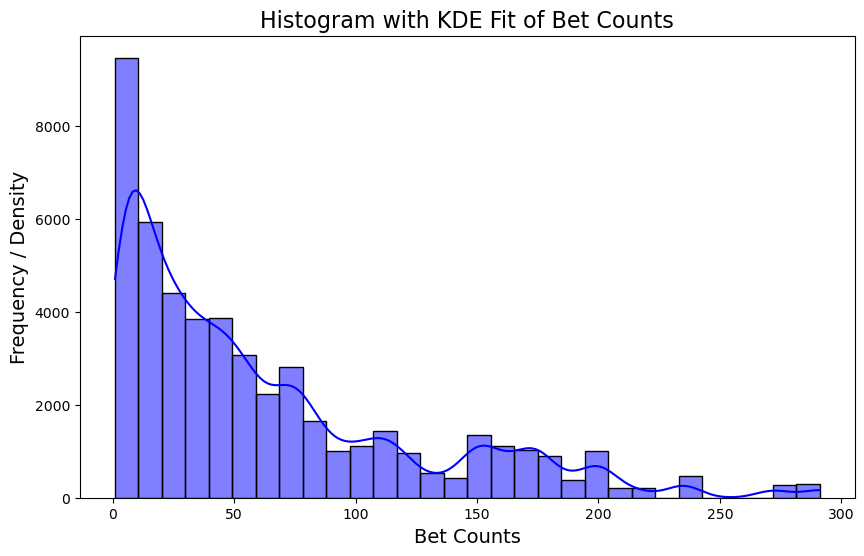

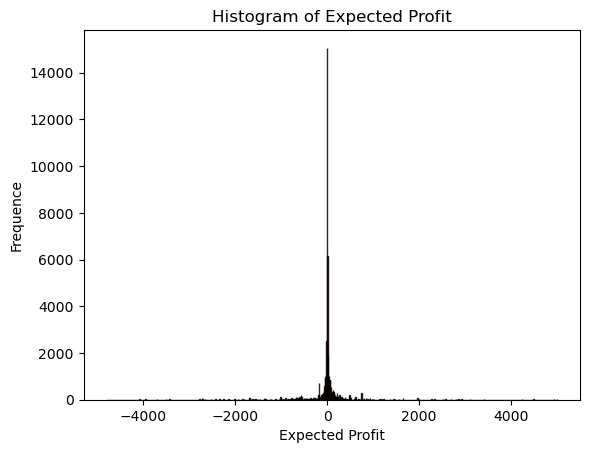

In [18]:
# 基于数据集研究风险承受水平对于决策收益的影响

data = pd.read_csv('./bustabit.csv').copy()

data.drop(['Id', 'GameID'], axis=1, inplace=True)


data = workflow(data)

data['Bet_Counts'] = data.groupby('Username')['Username'].transform('size')

data = signal_analyze(data)

data

'''
    绘制bet_signal的分布与期望分布之间的Q-Q图
'''

bool_series = pd.notnull(data['Bet_Signal'])
mean = data[bool_series]['Bet_Signal'].mean()
std = data[bool_series]['Bet_Signal'].std()
res = stats.probplot(data[bool_series]['Bet_Signal'],dist = stats.norm ,sparams=(mean,std))

# 绘制 QQ 图
plt.figure(figsize=(8, 6))
plt.plot(res[0][0], res[0][1], 'o', label='Observed Data')  # 数据点
plt.plot(res[0][0], res[0][0], 'r--', label='Theoretical Line')  # 理论分布线

# 添加标题和标签
plt.title('QQ Plot for Bet_Signal', fontsize=16)
plt.xlabel('Theoretical Quantiles', fontsize=14)
plt.ylabel('Sample Quantiles', fontsize=14)
plt.legend(fontsize=12)
plt.grid()

# 显示图表
plt.show()

'''
    绘制gambl次数的直方图
'''
sns.scatterplot(data =data, x= 'Bet_Counts',y= 'Expected_Profit',color = 'blue',s=12)
plt.title('Bet Counts VS. Expected Profit')
plt.xlabel('Bet Counts')
plt.ylabel('Expected Profit')
plt.show()

# 绘制带 KDE 曲线的直方图  每名玩家下注次数的直方图
plt.figure(figsize=(10, 6))
sns.histplot(data['Bet_Counts'], bins=30, kde=True, color='blue', edgecolor='black')

# 添加标题和轴标签
plt.title('Histogram with KDE Fit of Bet Counts', fontsize=16)
plt.xlabel('Bet Counts', fontsize=14)
plt.ylabel('Frequency / Density', fontsize=14)

# 显示图表
plt.show()

# 绘制每个人的期望下注回报

clipped_profit = [x for x in data['Expected_Profit'] if np.abs(x)<5000]
plt.hist(clipped_profit,bins = 1000,color = 'red',edgecolor = 'black',alpha = 0.85)
plt.title('Histogram of Expected Profit')
plt.xlabel('Expected Profit')
plt.ylabel('Frequence')
plt.show()
